In [151]:
import numpy as np
import pandas as pd
import copy
import os

from fastai.vision.all import *
from fastai.text.all import *
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

import torchtext
from torchtext.data import get_tokenizer
from collections import Counter

import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import PIL
from PIL import Image

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from evaluate import load

In [152]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [153]:
captions_path = "./train.csv"
images_path = "./train/"

In [154]:
df = pd.read_csv(captions_path)
print(len(df))
df.head()

74565


,img_name,img_path,mos,comments
0,41wy7upxzl,./train/41wy7upxzl.jpg,5.569231,"the pink and blue really compliment each other. like the dense color, blur."
1,ygujjq6xxt,./train/ygujjq6xxt.jpg,6.103175,love rhubarb! great colors!
2,wk321130q0,./train/wk321130q0.jpg,5.541985,i enjoy the textures and grungy feel to this. i also really like the deep rich red color.
3,w50dp2zjpg,./train/w50dp2zjpg.jpg,6.234848,"i like all the different colours in this pic, the brown, green, dark grey, light grey, cool image."
4,l7rqfxeuh0,./train/l7rqfxeuh0.jpg,5.190476,"i love these critters, just wish he was a little sharper, nice comp though."


## Data Preprocessing

In [155]:
stop_words = stopwords.words('english')
stop_words += ['would', 'youre', 'youve', 'youll', 'youd', 'shes', 'thatll', 'dont', 'shouldnt', 'shouldve', 'arent', 'couldnt', 'didnt', 'doesnt', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'wasnt', 'werent', 'wont', 'wouldnt']
stop_words += ['wow', 'woow', 'woowee', 'whoa', 'oh', 'ooh', 'woohoo', 'yes', 'ha', 'brr', 'duh', 'eww', 'hee', 'huh', 'hmm', 'hooray', 'jeez', 'omg', 'gosh', 'yay']

In [156]:
class my_dictionary(dict): 
    
    def __init__(self): 
        self = dict() 
          
    def add(self, key, value): 
        if key not in self.keys():
            self[key] = [value]
        else:
            self[key].append(value)
        
descriptors = my_dictionary() 

In [157]:
for i in range(len(df)):
    img_id = df.iloc[i, 0] + ".jpg"
    
    s = df.iloc[i, 3]
    s = re.sub('[^a-z]', ' ', s)
    sentence = ["<start>"] + word_tokenize(s) + ["<end>"]
    sentence = [word for word in sentence if len(word) > 1]
    sentence = [word for word in sentence if word not in stop_words]
    sentence = [word for word in sentence if 'haha' not in word]
    sentence = [word for word in sentence if 'hehe' not in word]
    sentence = [word for word in sentence if 'ah' not in word]
    
    descriptors.add(img_id, sentence)

In [158]:
print(descriptors['taibd7f1xk.jpg'])

[['<start>', 'one', 'pegged', 'blue', '<end>'], ['<start>', 'awesome', 'peaceful', 'almost', 'feel', 'myslef', 'love', 'colors', '<end>']]


In [159]:
token_counter = Counter()
class textVocab:
    def __init__(self):
        self.itos = {0:"<PAD>", 1:"<start>", 2:"<end>", 3:"<UNK>"}
        self.stoi = {b:a for a, b in self.itos.items()}   
        self.min_freq = 2
        self.token_counter = Counter()

    def __len__(self):
        return len(self.itos)

    def numericalize(self, text):

        text = re.sub('[^a-z]', ' ', text)
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if len(word) > 1]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [word for word in tokens if 'haha' not in word]
        tokens = [word for word in tokens if 'hehe' not in word]
        tokens = [word for word in tokens if 'ah' not in word]
        
        ans = []
        for token in tokens:
            if token in self.stoi.keys():
                ans.append(self.stoi[token]) 
            else:
                ans.append(self.stoi["<UNK>"])
        return ans

    def build_vocab(self, sentence_list):
        word_count = 4
        
        for sentence in sentence_list:
            
            sentence = re.sub('[^a-z]', ' ', sentence)
            tokens = word_tokenize(sentence)
            tokens = [word for word in tokens if len(word) > 1]
            tokens = [word for word in tokens if word not in stop_words]
            tokens = [word for word in tokens if 'haha' not in word]
            tokens = [word for word in tokens if 'hehe' not in word]
            tokens = [word for word in tokens if 'ah' not in word]
            
            token_counter.update(tokens)
            
            for token in tokens:
                if token_counter[token] >= self.min_freq and token not in self.stoi.keys():
                    self.stoi[token] = word_count
                    self.itos[word_count] = token
                    word_count += 1

In [160]:
class customDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        self.img_ids = self.df["img_name"]
        self.sentences = self.df["comments"]
        self.vocab = textVocab()
        self.vocab.build_vocab(self.sentences.tolist())
        print(len(self.vocab))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        img_id = self.img_ids[idx] + '.jpg'
        img_path = os.path.join(self.image_dir, img_id)

        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        vec = []
        vec += [self.vocab.stoi["<start>"]]
        vec += self.vocab.numericalize(sentence)
        vec += [self.vocab.stoi["<end>"]]
        
        return img, torch.tensor(vec), img_id

In [161]:
weights = models.Inception_V3_Weights.DEFAULT
inception = models.inception_v3(weights=weights)
i = 0
for name, param in inception.named_parameters():  # named_parameters 가중치 뽑아주는 함수
    print(i,name)
    i+= 1
print(weights.transforms())

0 Conv2d_1a_3x3.conv.weight
1 Conv2d_1a_3x3.bn.weight
2 Conv2d_1a_3x3.bn.bias
3 Conv2d_2a_3x3.conv.weight
4 Conv2d_2a_3x3.bn.weight
5 Conv2d_2a_3x3.bn.bias
6 Conv2d_2b_3x3.conv.weight
7 Conv2d_2b_3x3.bn.weight
8 Conv2d_2b_3x3.bn.bias
9 Conv2d_3b_1x1.conv.weight
10 Conv2d_3b_1x1.bn.weight
11 Conv2d_3b_1x1.bn.bias
12 Conv2d_4a_3x3.conv.weight
13 Conv2d_4a_3x3.bn.weight
14 Conv2d_4a_3x3.bn.bias
15 Mixed_5b.branch1x1.conv.weight
16 Mixed_5b.branch1x1.bn.weight
17 Mixed_5b.branch1x1.bn.bias
18 Mixed_5b.branch5x5_1.conv.weight
19 Mixed_5b.branch5x5_1.bn.weight
20 Mixed_5b.branch5x5_1.bn.bias
21 Mixed_5b.branch5x5_2.conv.weight
22 Mixed_5b.branch5x5_2.bn.weight
23 Mixed_5b.branch5x5_2.bn.bias
24 Mixed_5b.branch3x3dbl_1.conv.weight
25 Mixed_5b.branch3x3dbl_1.bn.weight
26 Mixed_5b.branch3x3dbl_1.bn.bias
27 Mixed_5b.branch3x3dbl_2.conv.weight
28 Mixed_5b.branch3x3dbl_2.bn.weight
29 Mixed_5b.branch3x3dbl_2.bn.bias
30 Mixed_5b.branch3x3dbl_3.conv.weight
31 Mixed_5b.branch3x3dbl_3.bn.weight
32 Mixe

In [162]:
class MyInceptionFeatureExtractor(nn.Module):
    def __init__(self, inception, transform_input=False):
        super(MyInceptionFeatureExtractor, self).__init__()
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = inception.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception.Conv2d_2b_3x3

        self.maxpool1 = inception.maxpool1
        self.Conv2d_3b_1x1 = inception.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception.Conv2d_4a_3x3
        self.maxpool2 = inception.maxpool2
        
        self.Mixed_5b = inception.Mixed_5b
        self.Mixed_5c = inception.Mixed_5c
        self.Mixed_5d = inception.Mixed_5d
        self.Mixed_6a = inception.Mixed_6a
        self.Mixed_6b = inception.Mixed_6b
        self.Mixed_6c = inception.Mixed_6c
        self.Mixed_6d = inception.Mixed_6d
        self.Mixed_6e = inception.Mixed_6e
        
        self.AuxLogits = inception.AuxLogits
        
        self.Mixed_7a = inception.Mixed_7a
        self.Mixed_7b = inception.Mixed_7b
        self.Mixed_7c = inception.Mixed_7c

    def forward(self, x):

        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.maxpool1(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = self.maxpool2(x)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)
        
        return x

In [163]:
inception_Transform = T.Compose([
    T.Resize(342),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [164]:
dataset = customDataset(
    image_dir = images_path,
    captions_file = captions_path,
    transform = inception_Transform
)

9903


In [165]:
with open('vocab.pkl', 'wb') as file:
      
    pickle.dump(dataset.vocab, file)

In [166]:
def show_image(img, title=None):
    
    # unnormalize
    img[0] *= 0.229
    img[1] *= 0.224
    img[2] *= 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

03hgnq4mgk.jpg


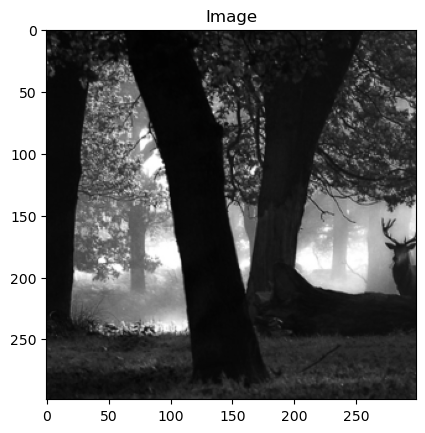

caption:  ['<start>', 'nice', 'capture', 'light', 'quality', 'nice', '<end>']


In [167]:
img, vec, img_id = dataset[8083]
print(img_id)
show_image(img, "Image")

caption = [dataset.vocab.itos[token] for token in vec.tolist()]
print("caption: ", caption)

In [168]:
class Collate_fn:
    def __init__(self, pad_value, batch_first=False):
        self.pad_value = pad_value
        self.batch_first = batch_first
        
    def __call__(self, batch):
        # get all inputs images
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        
        captions = [item[1] for item in batch]
        
        captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)
        
        img_ids = [item[2] for item in batch]
        
        return imgs, captions, img_ids

In [169]:
batch_size = 10
pad_value = dataset.vocab.stoi["<PAD>"]

In [170]:
validation_split = .8
test_split = .9
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))

val_split = int(np.floor(validation_split * dataset_size))
test_split = int(np.floor(test_split * dataset_size))
train_indices, val_indices, test_indices = indices[:val_split], indices[val_split:test_split], indices[test_split:]

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

In [171]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [172]:
train_loader = torch.utils.data.DataLoader(dataset, 
                                            batch_size=batch_size, shuffle=False,
                                            collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                            sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=test_sampler)

nice technique little saturation even shadows might improve picture


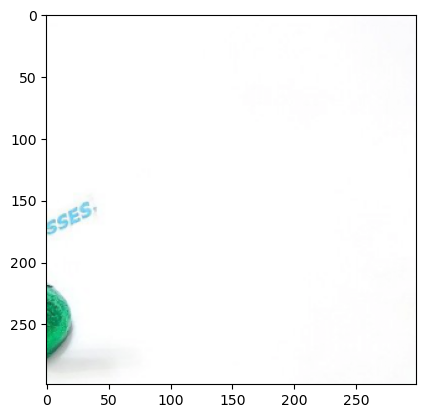

In [173]:
trainItr = iter(train_loader)
batch = next(trainItr)
imgs, captions, img_ids = batch

for i in range(batch_size):
    img, caption = imgs[i], captions[i]

    sentence = [dataset.vocab.itos[token] for token in caption.tolist()]

    end_indx = sentence.index('<end>')

    sentence = sentence[1:end_indx]
    sentence = ' '.join(sentence)

    print(sentence)
    show_image(img)
    plt.show()
    
    break

## Model

In [174]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.my_inception = MyInceptionFeatureExtractor(inception)
        
    def forward(self, images):
        # images.shape = [bs, 3, 299, 299]
        
        features = self.my_inception(images) 
        # features.shape = [bs, 2048, 8, 8]
        
        features = features.permute(0, 2, 3, 1)
        # features.shape = [bs, 8, 8, 2048]
        
        features = features.view(features.size(0), -1, features.size(-1))
        # features.shape = [bs, 64, 2048]
        #print(features.shape)
        
        return features

In [175]:
class Attention(nn.Module):
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.attention_dim = attention_dim
        
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
    
    def forward(self, features, hidden_states):
        att1 = self.encoder_att(features)   
        att2 = self.decoder_att(hidden_states)
        combined_states = torch.tanh(att1 + att2.unsqueeze(1))

        attention_scores = self.full_att(combined_states)
        attention_scores = attention_scores.squeeze(2)

        alpha = F.softmax(attention_scores, dim=1)

        weighted_encoding = features * alpha.unsqueeze(2)
        weighted_encoding = weighted_encoding.sum(dim=1)

        return alpha, weighted_encoding

In [176]:
import copy

class Decoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()

        self.vocab_sz = vocab_sz
        self.att_dim = att_dim
        self.dec_dim = dec_dim
        self.embedding = nn.Embedding(vocab_sz, embed_sz)
        self.attention = Attention(enc_dim, dec_dim, att_dim)
        
        self.init_h = nn.Linear(enc_dim, dec_dim)
        self.init_c = nn.Linear(enc_dim, dec_dim)
        
        self.lstm_cell = nn.LSTMCell(embed_sz + enc_dim, dec_dim, bias=True)
        
        self.f_beta = nn.Linear(dec_dim, enc_dim)
        self.fcn = nn.Linear(dec_dim, vocab_sz)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions, teacher):
        cap_len = len(captions[0]) - 1
        
        batch_sz = captions.size(0)
        num_features = features.size(1)
        embeds = self.embedding(captions)

        h, c = self.init_hidden_state(features)
        
        preds = torch.zeros(batch_sz, cap_len, self.vocab_sz).to(device)
        alphas = torch.zeros(batch_sz, cap_len, num_features).to(device)
        
        for i in range(cap_len):
            alpha, att_weights = self.attention(features, h)
            
            # use teacher forcing according teacher * 100%
            if i == 0 or np.random.rand() < teacher:
                lstm_input = torch.cat((embeds[:,i], att_weights), dim=1)
            else:
                # output 10,23756 -> argmax 10, 1 -> embed 10, 500
                output = [output[j, :].reshape(1, -1).argmax(dim=1).item() for j in range(batch_sz)]
                output = torch.tensor(np.array(output)).to(device)
                output = self.embedding(output)
                lstm_input = torch.cat((output, att_weights), dim=1)
            
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))

            preds[:, i] = output
            alphas[:, i] = alpha
            
        return preds, alphas
    
    def generate_caption(self, features, max_len=40, vocab=None, K=5):
        batch_sz = features.size(0)
        candidates = []
        final_candidates = []
        
        h, c = self.init_hidden_state(features)
        
        alphas = []
        captions = [vocab.stoi['<start>']]
        
        word = torch.tensor(vocab.stoi['<start>']).view(1, -1).to(device)
        embeds = self.embedding(word)
        
        # BeamSearch
        alpha, weighted_encoding = self.attention(features, h)
        lstm_input = torch.cat((embeds[:, 0], weighted_encoding), dim=1)
        h, c = self.lstm_cell(lstm_input, (h, c))
        output = self.fcn(self.drop(h))
        output = output.view(batch_sz, -1)
        output = output.squeeze(dim=0)
        output = F.log_softmax(output, dim=0)
        for i in range(K):
            pred_word_idx = output.argmax(dim=0).item()
            candidates.append([output[pred_word_idx].item(), output[pred_word_idx].item(), (h, c), [pred_word_idx]])
            output[pred_word_idx] = -999999
        
        while len(final_candidates) < K:
            new_candidates = []
            for candidate in candidates:
                word = torch.tensor(candidate[3][-1]).view(1,-1).to(device)
                embeds = self.embedding(word)
                h, c = candidate[2]
                alpha, weighted_encoding = self.attention(features, h)
                lstm_input = torch.cat((embeds[:, 0], weighted_encoding), dim=1)
                h, c = self.lstm_cell(lstm_input, (h, c))
                output = self.fcn(self.drop(h))
                output = output.view(batch_sz, -1)
                output = output.squeeze(dim=0)
                output = F.log_softmax(output, dim=0)

                for j in range(K):
                    pred_word_idx = output.argmax(dim=0).item()
                    new_candidates.append(copy.deepcopy(candidate))
                    new_candidates[-1][1] += output[pred_word_idx].item()
                    new_candidates[-1][2] = (h, c)
                    new_candidates[-1][0] = new_candidates[-1][1] / (((5+len(new_candidates[-1][3])) / (5+1)) ** 1.2)
                    #new_candidates[-1][0] = new_candidates[-1][1] / len(new_candidates[-1][3])
                    new_candidates[-1][3] += [pred_word_idx]
                    output[pred_word_idx] = -99999

            new_candidates.sort(key=lambda x:x[0], reverse=True)
            candidates = new_candidates[:K]
            
            for candidate in candidates[::]:
                if vocab.itos[candidate[3][-1]] == '<end>' or len(candidate[3]) > 40:
                    final_candidates.append(candidate)
                    candidates.remove(candidate)
        
        final_candidates.sort(key=lambda x:x[0], reverse=True)
        captions += final_candidates[0][3]
                    
        return [vocab.itos[idx] for idx in captions], None  # if idx != 0 and idx != 1 and idx != 2
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        
        return h, c

In [177]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = Encoder()
        
        # encoder freezing
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.decoder = Decoder(
            embed_sz = embed_sz,
            vocab_sz = vocab_sz,
            att_dim = att_dim,
            enc_dim = enc_dim,
            dec_dim = dec_dim
        )
    
    def forward(self, images, captions, teacher):

        features = self.encoder(images)
        outputs = self.decoder(features, captions, teacher)

        return outputs

In [178]:
embed_sz = 100
vocab_sz = len(dataset.vocab)
att_dim = 256
enc_dim = 2048
dec_dim = 512
learning_rate = 0.0001

In [179]:
model = EncoderDecoder(
    embed_sz = 100,
    vocab_sz = len(dataset.vocab),
    att_dim = 128,
    enc_dim = 2048,
    dec_dim = 256
).to(device)

In [180]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=False)

## Train

In [181]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [40]:
print_each = 100
epochs = 20

C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

<Figure size 640x480 with 0 Axes>

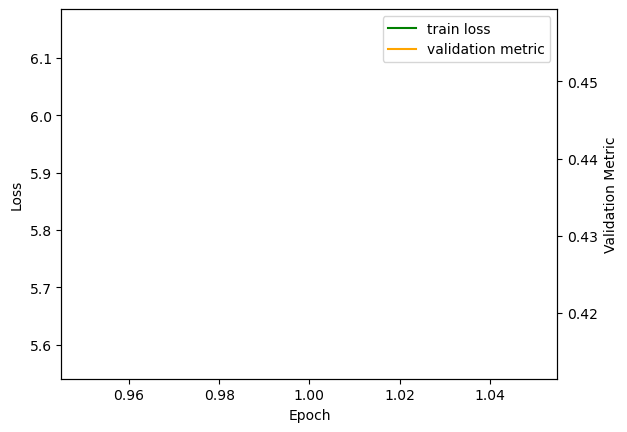

1 epochs : train_loss = 5.86279991782104, validation metric = 0.4354169443094577
BLEU: 0.311729
METEOR: 0.205649
BERT-Score: 0.878619
Rouge-L Score: 0.345670
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

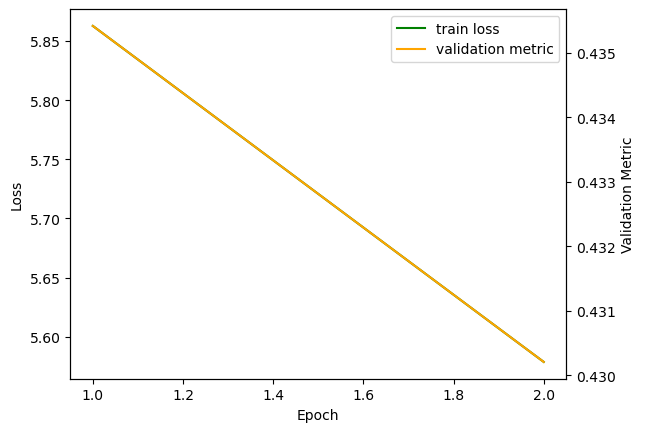

2 epochs : train_loss = 5.578609989345382, validation metric = 0.4302093847572742
BLEU: 0.311230
METEOR: 0.202662
BERT-Score: 0.876659
Rouge-L Score: 0.330286
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

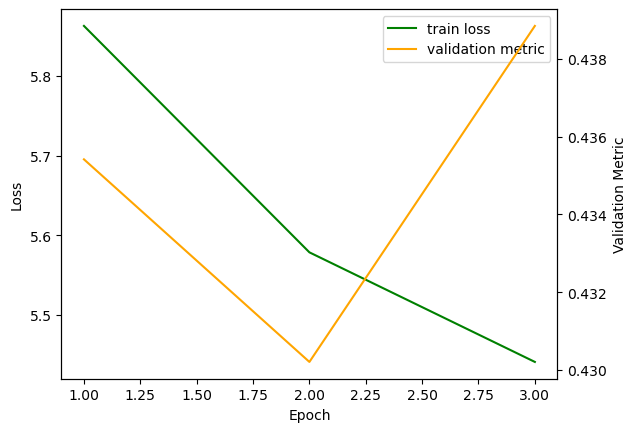

3 epochs : train_loss = 5.441068174541177, validation metric = 0.43884642497372867
BLEU: 0.326003
METEOR: 0.212622
BERT-Score: 0.878722
Rouge-L Score: 0.338039
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

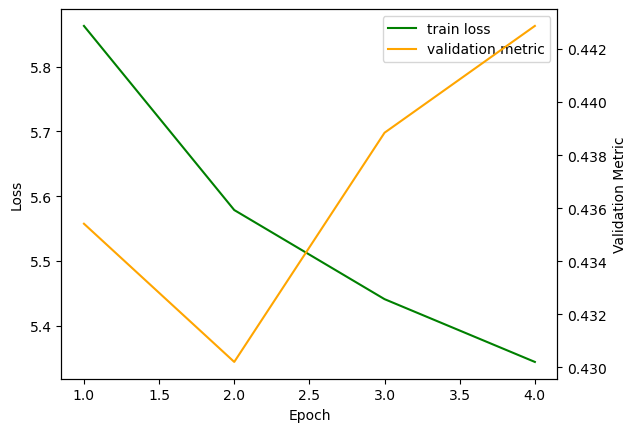

4 epochs : train_loss = 5.34418277099228, validation metric = 0.4428704834977069
BLEU: 0.330861
METEOR: 0.215985
BERT-Score: 0.884145
Rouge-L Score: 0.340492
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

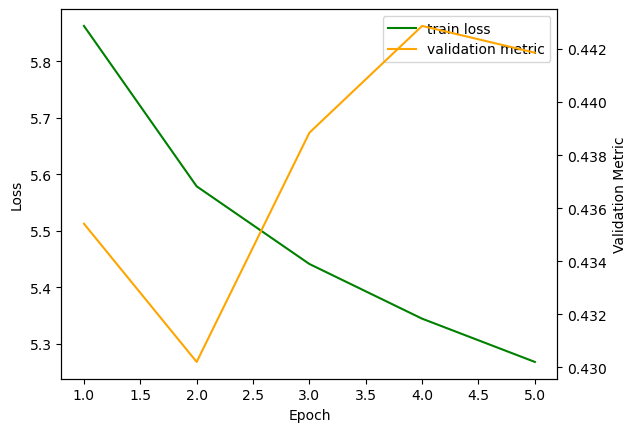

5 epochs : train_loss = 5.26759315027059, validation metric = 0.4418619999213893
BLEU: 0.333110
METEOR: 0.212620
BERT-Score: 0.883488
Rouge-L Score: 0.338229
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

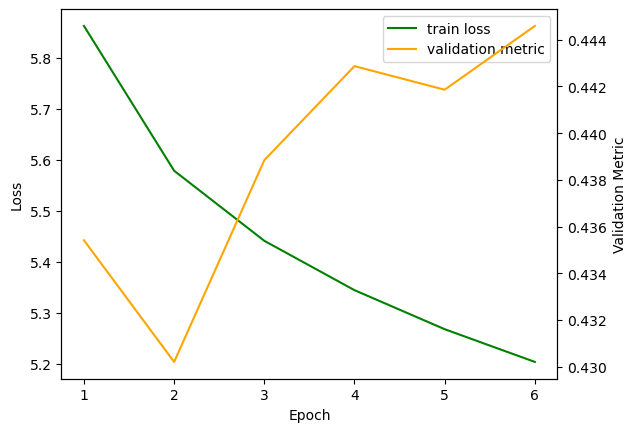

6 epochs : train_loss = 5.203371303490627, validation metric = 0.4445926367592271
BLEU: 0.336867
METEOR: 0.219833
BERT-Score: 0.882447
Rouge-L Score: 0.339223
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

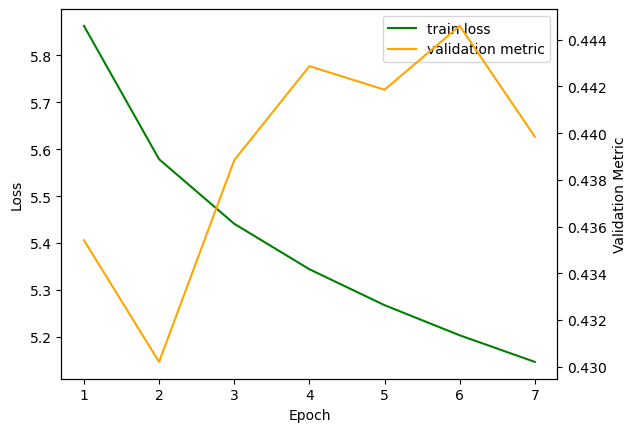

7 epochs : train_loss = 5.146633150119829, validation metric = 0.4398466840902717
BLEU: 0.328790
METEOR: 0.213882
BERT-Score: 0.881969
Rouge-L Score: 0.334746
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

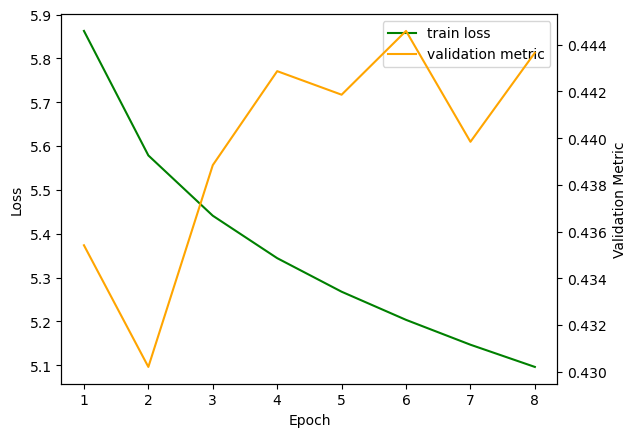

8 epochs : train_loss = 5.095952291416065, validation metric = 0.44365860403032836
BLEU: 0.332636
METEOR: 0.218315
BERT-Score: 0.883230
Rouge-L Score: 0.340454
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

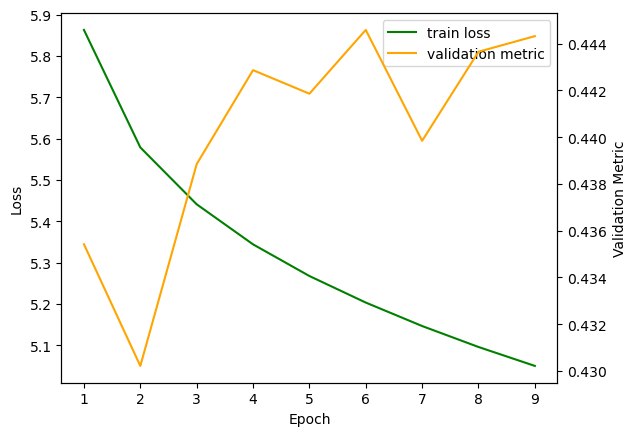

9 epochs : train_loss = 5.0501472524479745, validation metric = 0.4443262461377811
BLEU: 0.336769
METEOR: 0.217526
BERT-Score: 0.884327
Rouge-L Score: 0.338684
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

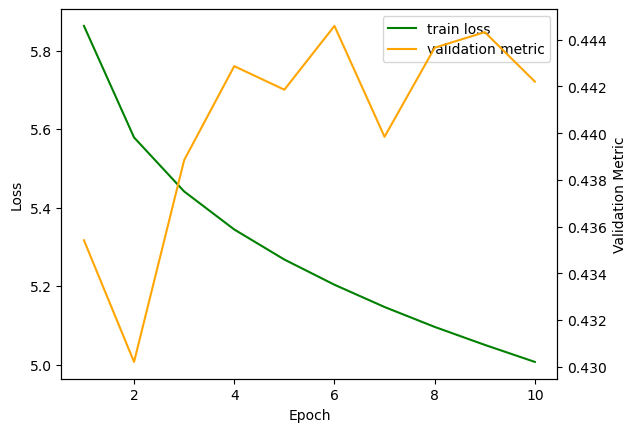

10 epochs : train_loss = 5.006722366634784, validation metric = 0.44220929669057685
BLEU: 0.334921
METEOR: 0.215404
BERT-Score: 0.882378
Rouge-L Score: 0.336135
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

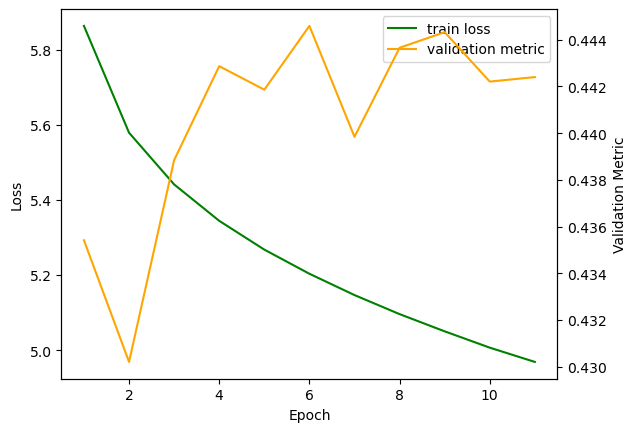

11 epochs : train_loss = 4.968773446707853, validation metric = 0.442402875036529
BLEU: 0.334882
METEOR: 0.215594
BERT-Score: 0.882989
Rouge-L Score: 0.336146
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

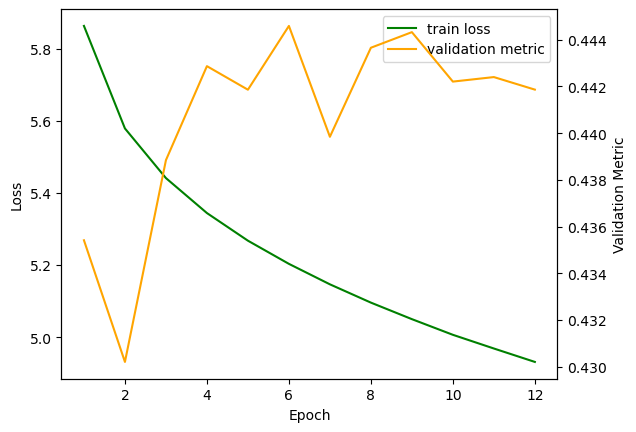

12 epochs : train_loss = 4.931582169682097, validation metric = 0.441866058368254
BLEU: 0.335030
METEOR: 0.214653
BERT-Score: 0.882300
Rouge-L Score: 0.335481
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

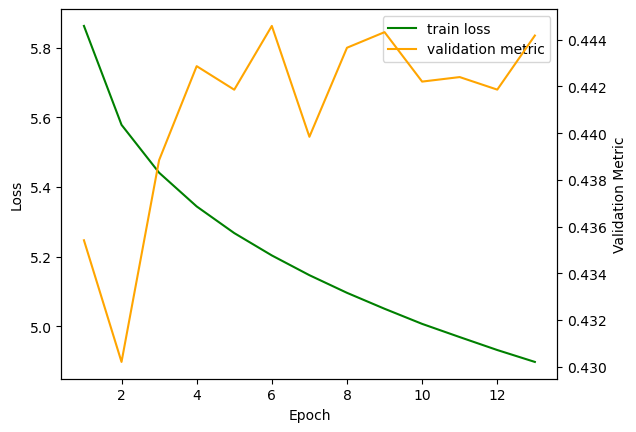

13 epochs : train_loss = 4.897418881153298, validation metric = 0.444180462268289
BLEU: 0.335792
METEOR: 0.217845
BERT-Score: 0.883819
Rouge-L Score: 0.339265
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

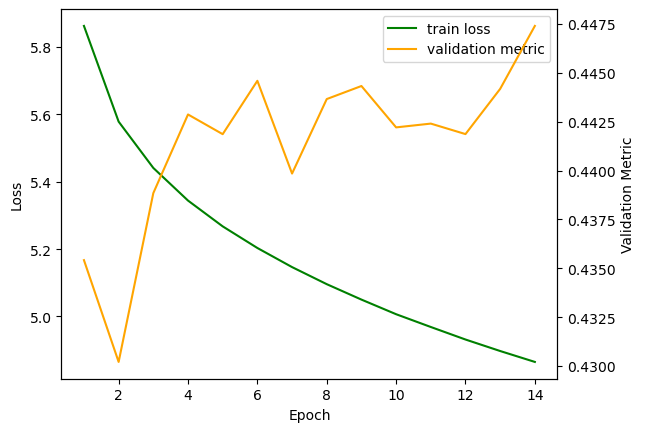

14 epochs : train_loss = 4.865055688948073, validation metric = 0.44740044435360526
BLEU: 0.341583
METEOR: 0.220651
BERT-Score: 0.885606
Rouge-L Score: 0.341762
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

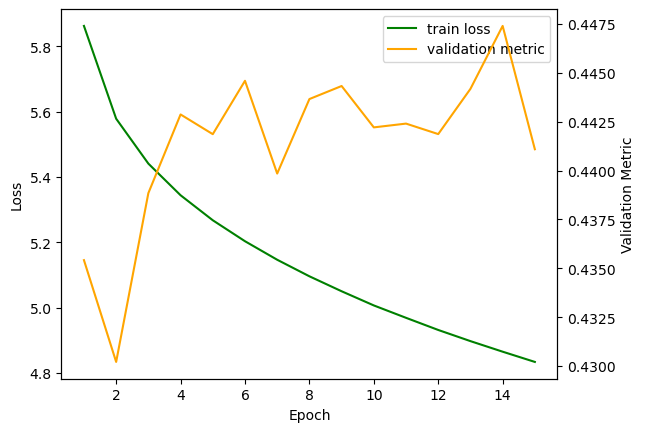

15 epochs : train_loss = 4.83371354209372, validation metric = 0.4410908817365291
BLEU: 0.332795
METEOR: 0.213427
BERT-Score: 0.882352
Rouge-L Score: 0.335790
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

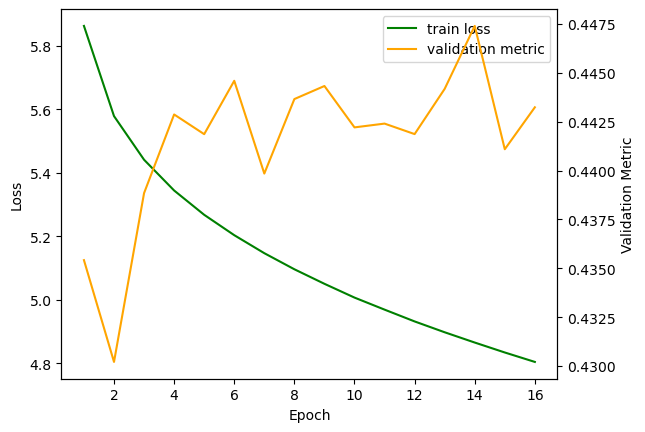

16 epochs : train_loss = 4.803978384943993, validation metric = 0.44323740572059034
BLEU: 0.336105
METEOR: 0.216849
BERT-Score: 0.883250
Rouge-L Score: 0.336745
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

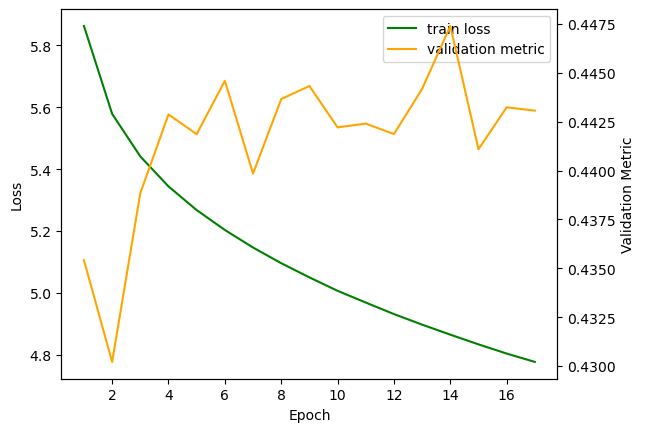

17 epochs : train_loss = 4.776954762230439, validation metric = 0.4430650002494623
BLEU: 0.336314
METEOR: 0.216752
BERT-Score: 0.882541
Rouge-L Score: 0.336654
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

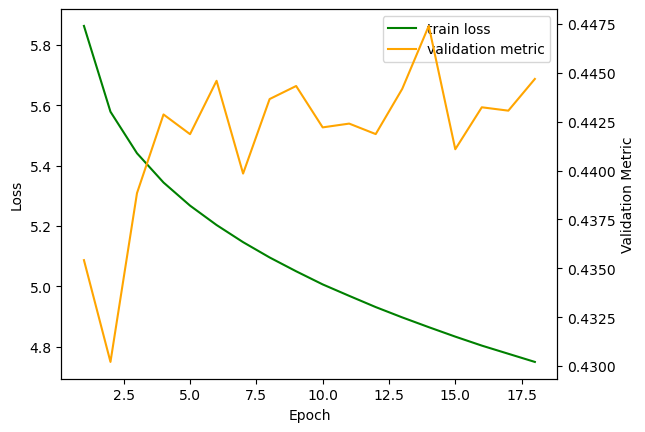

18 epochs : train_loss = 4.7499515687261065, validation metric = 0.4446879173877613
BLEU: 0.339252
METEOR: 0.218688
BERT-Score: 0.883234
Rouge-L Score: 0.337577
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

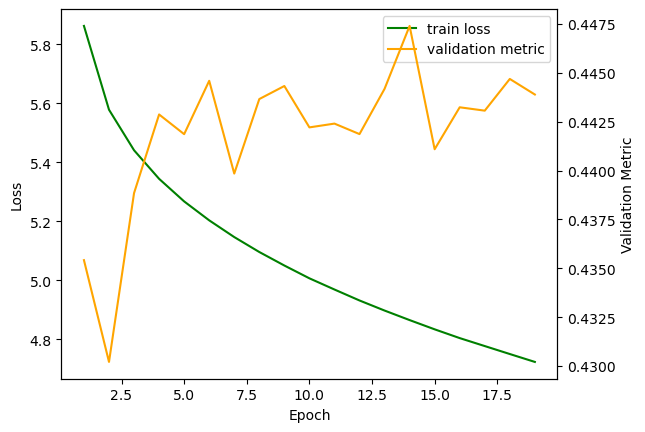

19 epochs : train_loss = 4.723171297632408, validation metric = 0.4438907954400539
BLEU: 0.337694
METEOR: 0.217604
BERT-Score: 0.883250
Rouge-L Score: 0.337015
current learning rate : 0.0001


<Figure size 640x480 with 0 Axes>

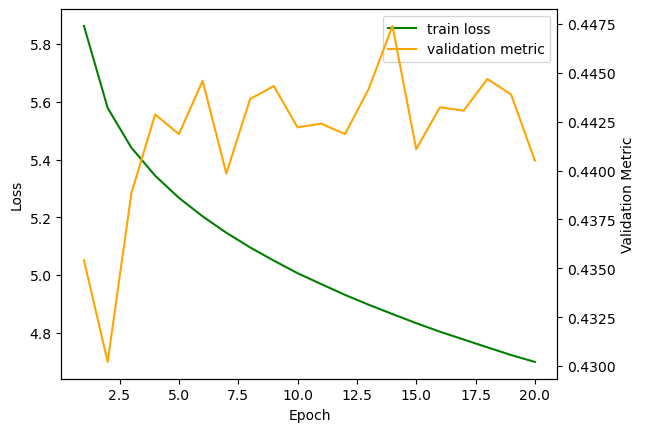

20 epochs : train_loss = 4.699382237495011, validation metric = 0.44051097331878913
BLEU: 0.333919
METEOR: 0.214381
BERT-Score: 0.881551
Rouge-L Score: 0.332194
current learning rate : 0.0001


In [33]:
train_loss = []
val_metric = []
highest_val = 0
bertscorer = load("bertscore")
rougescorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

for epoch in range(1, epochs+1):
    model.train()
    train_loss.append(0)
    val_metric.append(0)
    for idx, (img, captions, img_ids) in enumerate(iter(train_loader)):

        img, captions = img.to(device), captions.to(device)
        targets = captions[:, 1:]
        
        optimizer.zero_grad()
        
        pred_caps, attentions = model(img, captions, teacher=max(0, 1 - 0.005 * epoch))
        
        loss = criterion(pred_caps.view(-1, vocab_sz), targets.reshape(-1))
        train_loss[-1] += loss.item() * train_loader.batch_size
        
        loss.backward()
        optimizer.step()
    
    # Validaion calculate
    model.eval()
    bleu, meteor, bert_score, rougescore = 0, 0, 0, 0

    for idxx, (img, captions, img_ids) in enumerate(iter(val_loader)):
        with torch.no_grad():
            for i in range(batch_size):
                if len(captions[i:i+1]) == 0:
                    break
                    
                features = model.encoder(img[i:i+1].to(device))
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
                
                bleu += sentence_bleu(descriptors[img_ids[i]], pred_caps, weights=(1.0, 0, 0, 0))
                meteor += meteor_score(descriptors[img_ids[i]], pred_caps)
                bert_score_tmp, rougescore_tmp = 0, 0
                for j in range(len(descriptors[img_ids[i]])):
                    bert_score_tmp += bertscorer.compute(predictions=[' '.join(pred_caps)], references=[' '.join(descriptors[img_ids[i]][j])], model_type="distilbert-base-uncased")['f1'][0]
                    rougescore_tmp += rougescorer.score(' '.join(pred_caps), ' '.join(descriptors[img_ids[i]][j]))['rougeL'].fmeasure
                bert_score += bert_score_tmp / len(descriptors[img_ids[i]])
                rougescore += rougescore_tmp / len(descriptors[img_ids[i]])
    
    bleu = bleu / len(val_sampler)
    meteor = meteor / len(val_sampler)
    bert_score = bert_score / len(val_sampler)
    rougescore = rougescore / len(val_sampler)
    
    train_loss[-1] = train_loss[-1] / len(train_sampler)
    val_metric[-1] = bleu/4 + meteor/4 + bert_score/4 + rougescore/4
    #scheduler.step(val_metric[-1])
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    line1 = ax1.plot(list(range(1, epoch+1)), train_loss, color = 'green', label='train loss')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Metric')
    line2 = ax2.plot(list(range(1, epoch+1)), val_metric, color = 'orange', label='validation metric')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    plt.show()
    print(str(epoch) + " epochs : train_loss = " + str(train_loss[-1]) + ", validation metric = " + str(val_metric[-1]))
    print('BLEU: %f' % bleu)
    print('METEOR: %f' % (meteor))
    print('BERT-Score: %f' % (bert_score))
    print('Rouge-L Score: %f' % (rougescore))
    print("current learning rate : " + str(optimizer.param_groups[0]['lr']))
    
    # save latest model
    #if highest_val < val_metric[-1]:
    PATH = './weights/IQA_no14_' + str(epoch) + 'epochs.pt'
    torch.save(model.state_dict(), PATH)
    #highest_val = val_metric[-1]

In [ ]:
# PATH = './weights/IQA_no3_11epochs.pt'
# torch.save(model.state_dict(), PATH)

## Test

In [182]:
PATH = './weights/IQA_no14_14epochs.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Original: <start> good print quality nice idea <end>
Predicted: <start> nice use sepia tone <end>


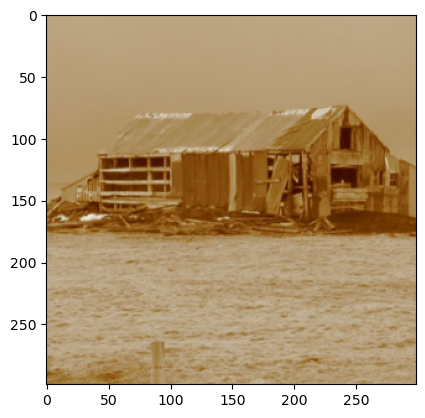

In [294]:
model.eval()
with torch.no_grad():
    itr = iter(val_loader)
    img, captions, img_ids = next(itr)
    
    caption = captions[0:1][0].tolist()
    s = [dataset.vocab.itos[idx] for idx in caption if idx != 0]
    print("Original:", ' '.join(s))
    
    features = model.encoder(img[0:1].to(device))

    pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    show_image(img[0])

In [43]:
bertscorer = load("bertscore")
rougescorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def evaluateModel(model, dls):
    model.eval()
    bleu, meteor, bert_score, rougescore = 0, 0, 0, 0
    
    for idxx, (img, captions, img_ids) in enumerate(iter(dls)):
        print(idxx)
        with torch.no_grad():
            
            for i in range(batch_size):
                if len(captions[i:i+1]) == 0:
                    break
                    
                features = model.encoder(img[i:i+1].to(device))
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

                bleu += sentence_bleu(descriptors[img_ids[i]], pred_caps, weights=(1.0, 0, 0, 0))
                meteor += meteor_score(descriptors[img_ids[i]], pred_caps)
                bert_score_tmp, rougescore_tmp = 0, 0
                for j in range(len(descriptors[img_ids[i]])):
                    bert_score_tmp += bertscorer.compute(predictions=[' '.join(pred_caps)], references=[' '.join(descriptors[img_ids[i]][j])], model_type="distilbert-base-uncased")['f1'][0]
                    rougescore_tmp += rougescorer.score(' '.join(pred_caps), ' '.join(descriptors[img_ids[i]][j]))['rougeL'].fmeasure
                bert_score += bert_score_tmp / len(descriptors[img_ids[i]])
                rougescore += rougescore_tmp / len(descriptors[img_ids[i]])
    
    print('BLEU: %f' % (bleu / len(val_sampler)))
    print('METEOR: %f' % (meteor / len(test_sampler)))
    print('BERT-Score: %f' % (bert_score / len(test_sampler)))
    print('Rouge-L Score: %f' % (rougescore / len(test_sampler)))

In [44]:
evaluateModel(model, test_loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27